In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('housing.csv')

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


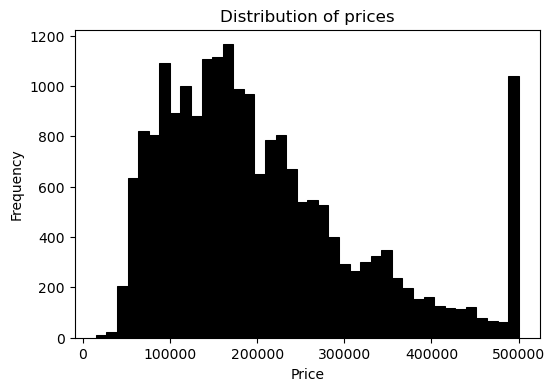

In [4]:
plt.figure(figsize=(6, 4))

sns.histplot(df["median_house_value"], bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

Although it clearly is skewed to the right, the tail is not that long, however there is clearly an outlier problem with high freqency values in the highest price range

In [5]:
df = df[['latitude','longitude','housing_median_age','total_rooms',
         'total_bedrooms','population','households','median_income',
         'median_house_value']]

In [6]:
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [7]:
df.population.median()

1166.0

In [8]:
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,37.88,-122.23,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,37.86,-122.22,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,37.85,-122.24,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,37.85,-122.25,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,37.85,-122.25,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


## Data preparation

In [9]:
n = len(df)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)
idx = np.arange(n)

In [10]:
np.random.seed(42)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx]
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [11]:
y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [12]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

In [13]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

### Prepare data filling with zeros

In [14]:
def prepare_X(df):
    df = df.fillna(0)
    X = df.values
    return X

In [15]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)
round(rmse(y_train, y_pred), 2)

0.34

### Prepare data filling with mean

In [16]:
def prepare_X(df):
    df = df.fillna(df.mean())
    X = df.values
    return X

In [17]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)
round(rmse(y_train, y_pred), 2)

0.34

Both are equally good when the rsme is rounded

### Regularization

In [18]:
def prepare_X(df):
    df = df.fillna(0)
    X = df.values
    return X

In [19]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

In [20]:
X_train = prepare_X(df_train)
for r in [0, 0.001, 0.01, 0.1, 1, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_train.dot(w)
    print(round(rmse(y_train, y_pred), 2))

0.34
0.34
0.34
0.34
0.35
0.35


### Validate the impact of the seed

In [21]:
results = []
for r in [0,1,2,3,4,5,6,7,8,9]:    
    np.random.seed(r)
    np.random.shuffle(idx)
    df_shuffled = df.iloc[idx]
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    y_train_orig = df_train.median_house_value.values
    y_val_orig = df_val.median_house_value.values
    y_test_orig = df_test.median_house_value.values

    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    X_train = prepare_X(df_train)
    w_0, w = train_linear_regression(X_train, y_train)
    y_pred = w_0 + X_train.dot(w)
    results.append(round(rmse(y_train, y_pred), 3))

In [22]:
round(np.std(results),3)

0.002

### Validate the model on the test data set

In [23]:
np.random.seed(9)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx]
df_train = df_shuffled.iloc[:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()
y_train_orig = df_train.median_house_value.values
y_test_orig = df_test.median_house_value.values
y_train = np.log1p(df_train.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)
del df_train['median_house_value']
del df_test['median_house_value']
X_train = prepare_X(df_train)
w_0, w =  train_linear_regression_reg(X_train, y_train, r=0.0)
X_test = prepare_X(df_test)
y_pred = w_0 + X_test.dot(w)
round(rmse(y_test, y_pred), 3)

0.345